In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import PIL
import time
from os import listdir
from os.path import isfile, join
import torch.nn.functional as F
from tqdm import tqdm_notebook
import util
import densenet as ds
import pspmodule as PSP

filelist = [f for f in listdir('D:/DataSet/AerialImageDataset/train/images') if isfile(join('D:/DataSet/AerialImageDataset/train/images', f))]
labels_path = 'D:/DataSet/AerialImageDataset/train/gt/'
images_path = 'D:/DataSet/AerialImageDataset/train/images/'
val_path = 'D:/DataSet/AerialImageDataset/train/val/'
plt.rcParams["figure.figsize"] = (12,8)
densenet = ds.densenet121(pretrained=True)
densenet

DenseNet(
  (features): Sequential(
    (conv0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm.1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm.2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (relu.2): ReLU(inplace)
        (conv.2): Conv2d (128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm.1): InstanceNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
        (relu.1): ReLU(inplace)
        (conv.1): Conv2d (96, 128, kernel_size=(1, 1), stride=(1, 1), bias=

In [2]:
for n,m in densenet.features.named_children():
    if('denseblock1') in n:
        for n,m in m.named_children():
            for n,m in m.named_children():
#                 print(n)
                if('conv.2') in n:
                    m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)

                    
    elif('denseblock2') in n:
        for n,m in m.named_children():
            for n,m in m.named_children():
#                 print(n)
                if('conv.2') in n:
                    m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)

#     elif('denseblock3') in n:
#         for n,m in m.named_children():
#             for n,m in m.named_children():
# #                 print(n)
#                 if('conv.2') in n:
#                     m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
# #                     print(m)

    

In [3]:

class Dense_Net_Feature(nn.Module):
    def __init__(self):
        super(Dense_Net_Feature, self).__init__()
        
        
        self.layer0 = nn.Sequential(densenet.features.conv0, densenet.features.norm0, densenet.features.relu0, densenet.features.pool0)
        self.denseblock1 = densenet.features.denseblock1
        self.transition1 = densenet.features.transition1
        self.denseblock2 = densenet.features.denseblock2
        self.transition2 = densenet.features.transition2
        self.denseblock3 = densenet.features.denseblock3
        self.transition3 = densenet.features.transition3
        self.denseblock4 = densenet.features.denseblock4
        self.transition4 = densenet.features.transition4
        self.denseblock5 = densenet.features.denseblock5
        
        self.final = nn.Sequential(
            nn.Conv2d(25, 14, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(14, 2, kernel_size=1)
        )
        
        self.psp = PSP.PSPModule(512)
        self.up1 = PSP.PSPUpsample(256,128)
        self.up2 = PSP.PSPUpsample(128,10)
        self.up3 = PSP.PSPUpsample(10,5)
        
        self.reducedim0 = nn.Conv2d(256,5,kernel_size=3,padding=1,bias=False)
        self.reducedim1 = nn.Conv2d(512,5,kernel_size=3,padding=1,bias=False)
        self.reducedim2 = nn.Conv2d(1024,5,kernel_size=3,padding=1,bias=False)
        self.reducedim3 = nn.Conv2d(1024,5,kernel_size=3,padding=1,bias=False)
        self.reducedim4 = nn.Conv2d(1024,5,kernel_size=3,padding=1,bias=False)

    def forward(self, x):
        x_size = x.size()
        
        out = self.layer0(x)
        
        
        out = self.denseblock1(out)
        
        
        upsample0 = F.upsample(self.reducedim0(out),x_size[2:],mode='bilinear')
        out = self.transition1(out)
        

        out = self.denseblock2(out)
        p = self.psp(out)
        p = self.up1(p,(x_size[2]//4,x_size[3]//4))
        p = self.up2(p,(x_size[2]//2,x_size[3]//2))
        p = self.up3(p,(x_size[2],x_size[3]))
#         print(p.size())
        
        upsample1 = F.upsample(self.reducedim1(out),x_size[2:],mode='bilinear')
        out = self.transition2(out)
        
        
        out = self.denseblock3(out)
        
        upsample2 = F.upsample(self.reducedim2(out),x_size[2:],mode='bilinear')
        out = self.transition3(out)
        
        out = self.denseblock4(out)
        upsample3 = F.upsample(self.reducedim3(out),x_size[2:],mode='bilinear')
        out = self.transition4(out)
        
        out = self.denseblock5(out)
        upsample4 = F.upsample(self.reducedim4(out),x_size[2:],mode='bilinear')
        
        out = self.final(torch.cat((upsample0,p,upsample2,upsample3,upsample4),1))
        
        return out


In [4]:
densenet_f = Dense_Net_Feature()

# densenet_f = densenet_f.cuda()
# densenet_f
def test_acc(densenet_f):
    
    test_list = ['austin1.tif','austin2.tif','austin3.tif','austin4.tif','austin5.tif',
                 'chicago1.tif','chicago2.tif','chicago3.tif','chicago4.tif','chicago5.tif',
                 'kitsap1.tif','kitsap2.tif','kitsap3.tif','kitsap4.tif','kitsap5.tif',
                 'tyrol-w1.tif','tyrol-w2.tif','tyrol-w3.tif','tyrol-w4.tif','tyrol-w5.tif',
                 'vienna1.tif','vienna2.tif','vienna3.tif','vienna4.tif','vienna5.tif'
                ]
    TEST_SIZE = 1000
    test_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    total_acc = 0.0
    for file in test_list:
        test_im = test_transform(PIL.Image.open(val_path+file)).unsqueeze(0)
        label_im = PIL.Image.open(labels_path+file)
        label_im = np.asarray(label_im)
        label_im = label_im==255
        for i in range(5000//TEST_SIZE):
            for j in range(5000//TEST_SIZE):
                
                test = Variable(test_im[:,:,i*TEST_SIZE:i*TEST_SIZE+TEST_SIZE,j*TEST_SIZE:j*TEST_SIZE+TEST_SIZE].cuda(),volatile=True)
                densenet_f.eval()
                out = densenet_f(test)
                m = nn.Softmax2d()
                out = m(out)
                out = (out.cpu()[0].data.numpy()).transpose((1, 2, 0))
                out_predict = out[:,:,1]>out[:,:,0]
                label_im_test = label_im[i*TEST_SIZE:i*TEST_SIZE+TEST_SIZE,j*TEST_SIZE:j*TEST_SIZE+TEST_SIZE]
    #             plt.imshow(~np.logical_xor(out_predict,label_im_test))
    #             plt.show()
                acc = ((~np.logical_xor(out_predict,label_im_test))*1.0).sum()/(TEST_SIZE*TEST_SIZE)
                total_acc+=acc
#                 print('filename = {}, (i,j) = {},{} ,ACC={}'.format(file,i,j,acc))
    total_acc = total_acc / ((5000//TEST_SIZE)*(5000//TEST_SIZE)*len(test_list))
    print('total_acc: ',total_acc)   
    return total_acc

In [16]:
def train_model(model ,criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    CROP_SIZE =500
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_loss = np.inf
    for epoch in range(num_epochs):
        rand_sample = np.random.randint(len(filelist), size=1)
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        
        # Each epoch has a training and validation phase
        
            
#         scheduler.step()
        model.train(True)  # Set model to training mode
        running_loss = 0.0
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        out_transform = transforms.Compose([
                transforms.ToTensor(),
#                 normalize
        ])
        out_transform_lebel = transforms.Compose([
                transforms.ToTensor()
#                 normalize
        ])
        # Iterate over data.
        count = 0
        cum = 0
        for index in tqdm_notebook(rand_sample,total=1):
            im = PIL.Image.open(join(images_path,filelist[index]))
            labels_data = PIL.Image.open(join(labels_path,filelist[index]))
            
            train_data = out_transform(im)
            labels_data = out_transform_lebel(labels_data)
            im.close()
            for i in range(5000//CROP_SIZE):
                for j in range(5000//CROP_SIZE):
                    
                    labels_data_tem = Variable(labels_data[:,i*CROP_SIZE:i*CROP_SIZE+CROP_SIZE,j*CROP_SIZE:j*CROP_SIZE+CROP_SIZE].type(torch.LongTensor).cuda())
                    cum = torch.sum(labels_data_tem).cpu().data.numpy()[0]
#                     if cum < CROP_SIZE*CROP_SIZE*0.001:
#                         continue
                    count+=1
                    train_data_tem = train_data[:,i*CROP_SIZE:i*CROP_SIZE+CROP_SIZE,j*CROP_SIZE:j*CROP_SIZE+CROP_SIZE].unsqueeze(0)
                    train_data_tem = Variable(train_data_tem.cuda())
                    
# #                     print(train_data_tem.size())
                    
                    # zero the parameter gradients
        
                    # forward
                    outputs= model(train_data_tem)
#                     print(labels_data.size())
                    loss = criterion(outputs,labels_data_tem) 
                    
                    
        
                    #loss = MSE(outputs, inputs_eva)
                    # backward + optimize only if in training phase
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    # statistics
                    running_loss += loss.data[0]
        epoch_loss = running_loss / count
        print('Loss: {:.4f} Iteration:{}'.format(epoch_loss,count))
        tem_acc = test_acc(model)  
#         print('Acc: {}'.format(test_acc))
#         if(tem_acc>best_acc):
#             best_model_wts = model.state_dict()
#             best_acc = tem_acc
        
    # deep copy the model
    print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # load best model weights
#     model.load_state_dict(best_model_wts)
    return model

In [ ]:
# densenet_f.load_state_dict(torch.load('DenseNet121_instance_onemore_PSP0.pt'))
# use_gpu = torch.cuda.is_available()
# if use_gpu:
#     densenet_f = densenet_f.cuda()
# criterion = util.CrossEntropyLoss2d(size_average=True).cuda()
optimizer_ft = optim.Adam(densenet_f.parameters(), lr=0.0000001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)
densenet_f = train_model(densenet_f,criterion,optimizer_ft,exp_lr_scheduler,1)

Epoch 0/0
----------


C:\Users\user\PycharmProjects\DIP_final\util.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.nll_loss(F.log_softmax(inputs), targets)



Loss: 0.0468 Iteration:100


In [15]:
torch.save(densenet_f.state_dict(),'DenseNet121_instance_onemore_PSP0.pt')

In [ ]:
densenet_f.load_state_dict(torch.load('DenseNet121_instance_onemore_PSP0.pt'))
use_gpu = torch.cuda.is_available()
if use_gpu:
    densenet_f = densenet_f.cuda()    

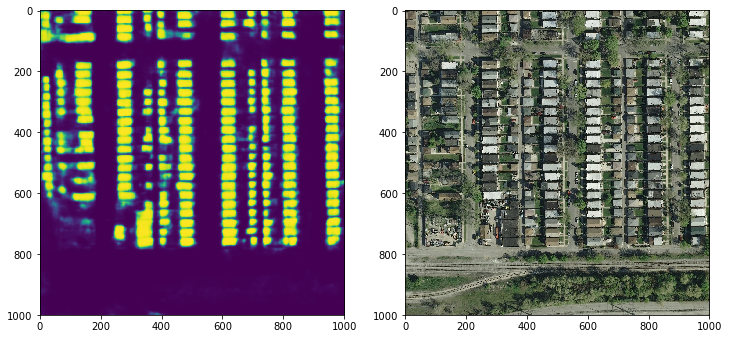

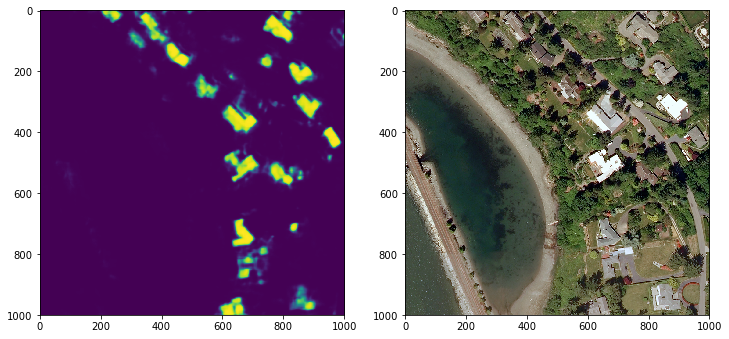

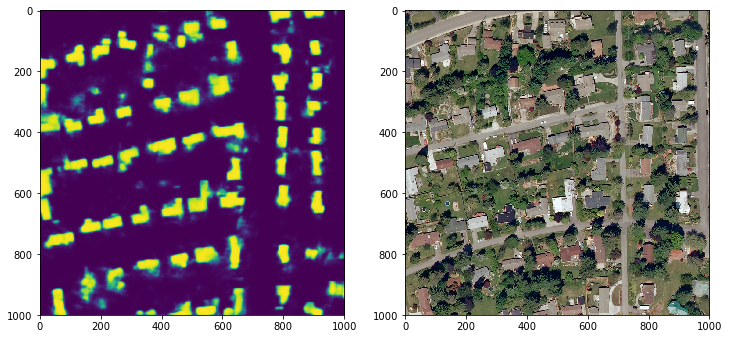

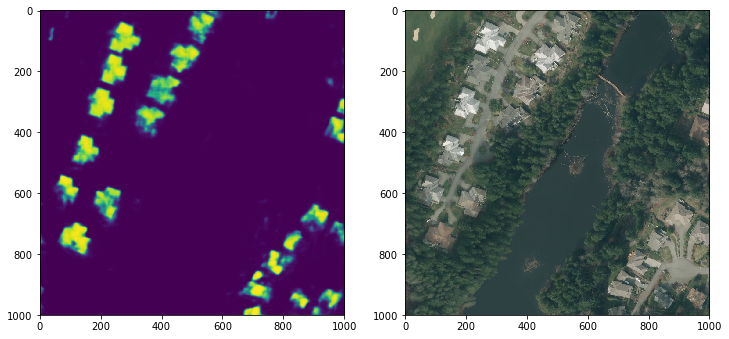

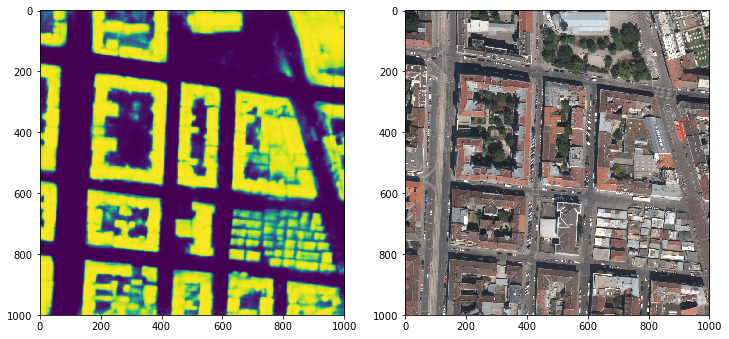

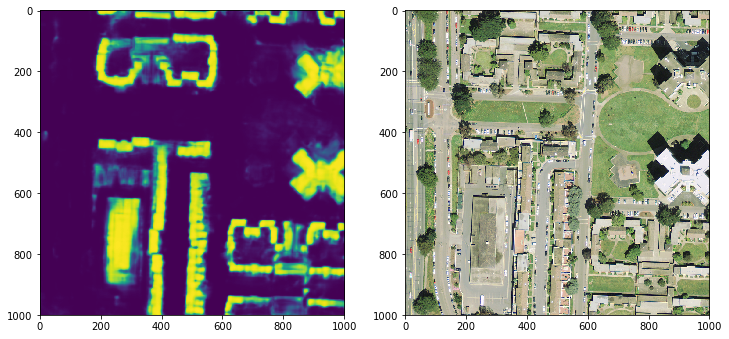

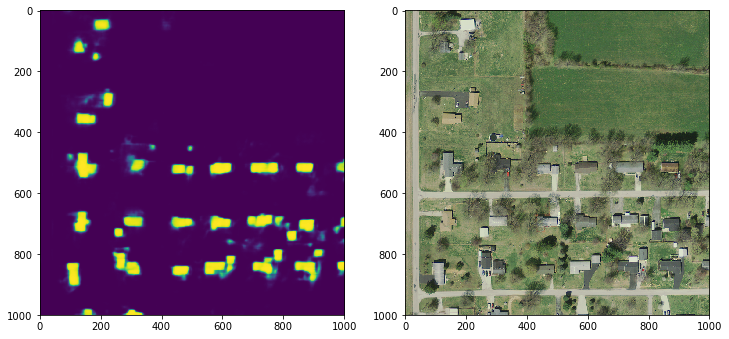

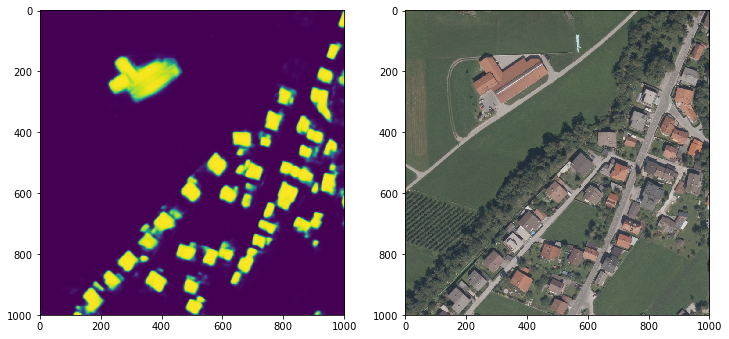

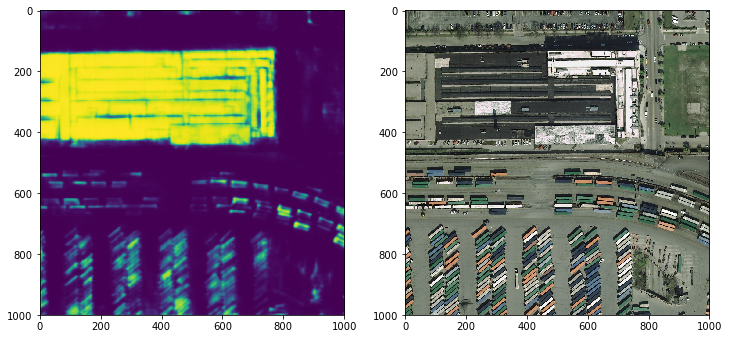

In [14]:
test_list = ['chi1.jpg',
             'bell1.tif',
             'bell2.tif',
             'kit1.jpg',
             'vie1.jpg',
             'sfo1_cr.png',
             'bloomington1_cr.png',
             'innsbruck1_cr.png',
             'chicago15_cr.png'
            ]
for index in range(len(test_list)):
    
    test_path = test_list[index]
    test_transform = transforms.Compose([
        transforms.ToTensor()
    ])
    test = test_transform(PIL.Image.open(test_path)).unsqueeze(0)
    test = Variable(test.cuda(),volatile=True)
    densenet_f.eval()
    out = densenet_f(test)

    
    m = nn.Softmax2d()
    n = nn.Tanh()
    out = m(out)
    out = (out.cpu()[0].data.numpy()).transpose((1, 2, 0))
    
    
    
    f,ax = plt.subplots(1,2)
    a = out[:,:,1].copy()
    a[a<0] = 0
    ax[0].imshow(out[:,:,1])
    ax[1].imshow(np.array(PIL.Image.open(test_path)))
    plt.show()

# a.save('kit1_source.tif')


In [ ]:
b = out[:,:,0].copy()
b[b>0] = 0
b *= -1
plt.imshow(b>0)
plt.show()